In [262]:
# *****************************************************
# * Import required packages and set up path for ODYM *
# *****************************************************
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.dataprovider import DataProvider
from core.datachecker import DataChecker
from core.datavisualizer import DataVisualizer
from core.network_graph import NetworkGraph
from core.flowsolver import FlowSolver
from core.parameters import ParameterName
from core.utils import setup_current_working_directory, setup_odym_directories, create_output_directory, \
    setup_scenario_output_directories, \
    calculate_scenario_mass_balance, build_mfa_system_for_scenario, shorten_sheet_name,\
    show_exception_errors, show_model_parameters

# NOTE: These needs to be called before importing ODYM classes
setup_current_working_directory()
setup_odym_directories()
create_output_directory(os.path.join(os.getcwd(), "output"))

In [263]:
# ******************************************************
# * Step 1: Load the data from Excel file DataProvider *
# ******************************************************

# Load data from file using the DataProvider
# and get model parameters from the file
filename = "data/FPs_SSP3/Input_FPs_SSP3.xlsx"
#filename = "data/example_data.xlsx"


print("Loading data from file {}...".format(filename))
dataprovider = None
try:
    dataprovider = DataProvider(filename)
except Exception as ex:
    show_exception_errors(ex, "Following errors occurred when loading settings file:")
    print("Fatal error, stopping execution...")
    raise ex

# Model parameters is a Dictionary that contains loaded data from Excel sheet named "Settings"
# and are used for running the FlowSolver and setting up ODYM
model_params = dataprovider.get_model_params()
show_model_parameters(model_params)

# Setup output path
# NOTE: This only works inside Notebook, executable might need __file__?
# Convert output directory name to absolute path and update model parameter dictionary
model_params[ParameterName.OutputPath] = os.path.abspath(
    os.path.join(os.getcwd(), model_params[ParameterName.OutputPath]))

Loading data from file data/FPs_SSP3/Input_FPs_SSP3.xlsx...
Using following parameters for running the model:
	sheet_name_processes            = Processes
	skip_num_rows_processes         = 2
	ignore_columns_processes        = ['A']
	sheet_name_flows                = Flows
	skip_num_rows_flows             = 2
	ignore_columns_flows            = ['A']
	start_year                      = 1900
	end_year                        = 2050
	detect_year_range               = False
	use_virtual_flows               = True
	virtual_flows_epsilon           = 0.1
	baseline_value_name             = SWE
	baseline_unit_name              = Mm3
	conversion_factor_c_to_co2      = 3.67
	fill_missing_absolute_flows     = False
	fill_missing_relative_flows     = True
	fill_method                     = Previous
	use_scenarios                   = True
	sheet_name_scenarios            = Scenarios
	ignore_columns_scenarios        = []
	sheet_name_colors               = Colors
	ignore_columns_colors           = []
	c

In [264]:
# **************************************************************
# * Step 2: Check data integrity and build data for FlowSolver *
# **************************************************************

print("Checking errors in data...")
data_checker = DataChecker(dataprovider)

# Build scenarios
scenarios = []
try:
    scenarios = data_checker.build_scenarios()
except Exception as ex:
    show_exception_errors(ex, "Following errors occurred when building scenarios:")
    print("Fatal error, stopping execution...")
    raise ex

# Check for build scenario errors
try:
    data_checker.check_for_errors()
except Exception as ex:
    show_exception_errors(ex, "Following errors found when checking scenario errors:")
    print("Fatal error, stopping execution...")
    raise ex

# Create network graph for data
# scenarios[0] is always the baseline scenario and is guaranteed to exist
if model_params[ParameterName.CreateNetworkGraphs]:
    network_visualizer = NetworkGraph()
    network_visualizer.build(scenarios[0].scenario_data)
    network_visualizer.show(os.path.join(model_params[ParameterName.OutputPath], "network_graph.html"))


Checking errors in data...
Checking processes for inflow visualization...
Checking flow source and target processes...
Checking multiple flow definitions in the same year...
Checking process stock parameters...
Checking stock distribution types...
Checking stock distribution parameters...
Checking stocks in isolated processes...
Merge relative outflows...
Checking root processes...
Checking relative flow errors...
Checking processes with no inflows and only relative outflows...
Checking for processes that have no inflows and only relative outflows...
Checking isolated/unconnected processes...
Checking prioritized locations...
Checking prioritized transformation stages...
Checking scenario definitions...
Checking color definitions...
INFO: Color definition name 'by_prod' is not transformation stage name (row 8)
INFO: Color definition name 'Virtual' is not transformation stage name (row 9)
Checking flow indicators...
INFO: Flow 'Black_liquor:EU27+3 CHP:EU27+3' has no conversion factor de

In [265]:
# ******************************************************************
# * Step 3: Solve flows for baseline scenario using the FlowSolver *
# ******************************************************************
for scenario_index, scenario in enumerate(scenarios):
    # NOTE: Baseline scenario is always the first element in the list
    # and all the alternative scenarios (if any) are after that
    if scenario_index == 0:
        # Process baseline scenario
        baseline_flow_solver = FlowSolver(scenario=scenario)
        baseline_flow_solver.solve_timesteps()
        scenario.flow_solver = baseline_flow_solver
    else:
        # Get and copy solved scenario data from baseline scenario flow solver
        baseline_scenario_data = scenarios[0].flow_solver.get_solved_scenario_data()
        scenario.copy_from_baseline_scenario_data(baseline_scenario_data)

        # Solve this alternative scenario time steps
        scenario_flow_solver = FlowSolver(scenario=scenario)
        scenario_flow_solver.solve_timesteps()
        scenario.flow_solver = scenario_flow_solver


Solving flows for year 1912/2050: : 12it [00:00, 53.84it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1900)
Created 1 virtual processes and 1 virtual flows for year 1900
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=16.183)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1901)
Created 1 virtual processes and 1 virtual flows for year 1901
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=16.429)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1902)
Created 1 virtual processes and 1 virtual flows for year 1902
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=16.679)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1903)
Created 1 virtual

Solving flows for year 1926/2050: : 26it [00:00, 61.23it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1912)
Created 1 virtual processes and 1 virtual flows for year 1912
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=19.398)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1913)
Created 1 virtual processes and 1 virtual flows for year 1913
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=19.693)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1914)
Created 1 virtual processes and 1 virtual flows for year 1914
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=19.992)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1915)
Created 1 virtual

Solving flows for year 1945/2050: : 46it [00:00, 82.43it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1927)
Created 1 virtual processes and 1 virtual flows for year 1927
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=24.328)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1928)
Created 1 virtual processes and 1 virtual flows for year 1928
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=24.699)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1929)
Created 1 virtual processes and 1 virtual flows for year 1929
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=25.074)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1930)
Created 1 virtual

Solving flows for year 1963/2050: : 63it [00:00, 86.40it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1946)
Created 1 virtual processes and 1 virtual flows for year 1946
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=32.413)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1947)
Created 1 virtual processes and 1 virtual flows for year 1947
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=32.906)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1948)
Created 1 virtual processes and 1 virtual flows for year 1948
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=33.406)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1949)
Created 1 virtual

Solving flows for year 1977/2050: : 77it [00:01, 78.16it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1963)
Created 1 virtual processes and 1 virtual flows for year 1963
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=34.84)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1964)
Created 1 virtual processes and 1 virtual flows for year 1964
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=37.965)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1965)
Created 1 virtual processes and 1 virtual flows for year 1965
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=36.412)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1966)
Created 1 virtual 

Solving flows for year 1993/2050: : 93it [00:01, 77.42it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1977)
Created 1 virtual processes and 1 virtual flows for year 1977
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=29.255)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1978)
Created 1 virtual processes and 1 virtual flows for year 1978
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=27.202)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1979)
Created 1 virtual processes and 1 virtual flows for year 1979
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=24.868)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1980)
Created 1 virtual

Solving flows for year 2019/2050: : 119it [00:01, 103.16it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1994)
Created 1 virtual processes and 1 virtual flows for year 1994
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=12.962)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1995)
Created 1 virtual processes and 1 virtual flows for year 1995
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=25.823)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1996)
Created 1 virtual processes and 1 virtual flows for year 1996
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=7.802)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (1997)
Created 1 virtual 

Solving flows for year 2041/2050: : 142it [00:01, 112.23it/s]

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (2019)
Created 1 virtual processes and 1 virtual flows for year 2019
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=8.986)'

2020: Create virtual inflow
Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (2021)
Created 1 virtual processes and 1 virtual flows for year 2021
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=3.205)'

Industrial_roundwood:EU27+3: Creating virtual flow, inflow=False, outflow=True (2022)
Created 1 virtual processes and 1 virtual flows for year 2022
	- Virtual process ID 'VP_Industrial_roundwood:EU27+3'
	- Virtual flow ID 'Industrial_roundwood:EU27+3 VP_Industrial_roundwood:EU27+3 (value=9.075)'

2023: Create virtual inflow
Industrial_roundwood:EU27+3: Creating virtual flow

Solving flows for year 2050/2050: : 151it [00:01, 89.35it/s] 


2042: Create virtual inflow
2043: Create virtual inflow
2044: Create virtual inflow
2045: Create virtual inflow
2046: Create virtual inflow
2047: Create virtual inflow
2048: Create virtual inflow
2049: Create virtual inflow
2050: Create virtual inflow


Solving flows for year 1925/2050: : 25it [00:00, 124.52it/s]

*** Applying flow modifiers for scenario 'Scenario 16 (flows to long lived 50% increase)' ***
34.2 34.2
34.2 34.833333333333336
34.2 35.46666666666667
34.2 36.1
34.2 36.733333333333334
34.2 37.36666666666667
34.2 38.0
34.2 38.63333333333334
34.2 39.266666666666666
34.2 39.900000000000006
34.2 40.53333333333334
34.2 41.16666666666667
34.2 41.800000000000004
34.2 42.43333333333334
34.2 43.06666666666667
34.2 43.7
34.2 44.333333333333336
34.2 44.96666666666667
34.2 45.60000000000001
34.2 46.233333333333334
34.2 46.866666666666674
34.2 47.5
34.2 48.13333333333334
34.2 48.76666666666667
34.2 49.400000000000006
34.2 50.03333333333334
34.2 50.66666666666667
34.2 51.300000000000004
7.6 7.6
7.6 7.7407407407407405
7.6 7.881481481481481
7.6 8.022222222222222
7.6 8.162962962962963
7.6 8.303703703703704
7.6 8.444444444444445
7.6 8.585185185185185
7.6 8.725925925925925
7.6 8.866666666666667
7.6 9.007407407407406
7.6 9.148148148148147
7.6 9.288888888888888
7.6 9.429629629629629
7.6 9.57037037037037
7

Solving flows for year 2046/2050: : 146it [00:01, 125.25it/s]

MDF_HDF:EU27+3: Creating virtual flow, inflow=True, outflow=False (2024)
OSB:EU27+3: Creating virtual flow, inflow=True, outflow=False (2024)
Particle_board:EU27+3: Creating virtual flow, inflow=True, outflow=False (2024)
Sawnwood:EU27+3: Creating virtual flow, inflow=True, outflow=False (2024)
Created 4 virtual processes and 4 virtual flows for year 2024
	- Virtual process ID 'VP_MDF_HDF:EU27+3'
	- Virtual process ID 'VP_OSB:EU27+3'
	- Virtual process ID 'VP_Particle_board:EU27+3'
	- Virtual process ID 'VP_Sawnwood:EU27+3'
	- Virtual flow ID 'VP_MDF_HDF:EU27+3 MDF_HDF:EU27+3 (value=0.25951)'
	- Virtual flow ID 'VP_OSB:EU27+3 OSB:EU27+3 (value=0.12794)'
	- Virtual flow ID 'VP_Particle_board:EU27+3 Particle_board:EU27+3 (value=0.88941)'
	- Virtual flow ID 'VP_Sawnwood:EU27+3 Sawnwood:EU27+3 (value=1.2932)'

Fibreboard:EU27+3: Creating virtual flow, inflow=True, outflow=False (2025)
MDF_HDF:EU27+3: Creating virtual flow, inflow=True, outflow=False (2025)
OSB:EU27+3: Creating virtual flow

Solving flows for year 2050/2050: : 151it [00:01, 125.17it/s]

Fibreboard:EU27+3: Creating virtual flow, inflow=True, outflow=False (2047)
MDF_HDF:EU27+3: Creating virtual flow, inflow=True, outflow=False (2047)
OSB:EU27+3: Creating virtual flow, inflow=True, outflow=False (2047)
Particle_board:EU27+3: Creating virtual flow, inflow=True, outflow=False (2047)
Plywood:EU27+3: Creating virtual flow, inflow=True, outflow=False (2047)
Sawnwood:EU27+3: Creating virtual flow, inflow=True, outflow=False (2047)
Created 6 virtual processes and 6 virtual flows for year 2047
	- Virtual process ID 'VP_Fibreboard:EU27+3'
	- Virtual process ID 'VP_MDF_HDF:EU27+3'
	- Virtual process ID 'VP_OSB:EU27+3'
	- Virtual process ID 'VP_Particle_board:EU27+3'
	- Virtual process ID 'VP_Plywood:EU27+3'
	- Virtual process ID 'VP_Sawnwood:EU27+3'
	- Virtual flow ID 'VP_Fibreboard:EU27+3 Fibreboard:EU27+3 (value=1.4533)'
	- Virtual flow ID 'VP_MDF_HDF:EU27+3 MDF_HDF:EU27+3 (value=8.1427)'
	- Virtual flow ID 'VP_OSB:EU27+3 OSB:EU27+3 (value=3.9284)'
	- Virtual flow ID 'VP_Partic

In [266]:
# ****************************************************************************
# * Step 4: Setup ODYM classifications and index table for each Scenario *
# ****************************************************************************

# Create output directory and scenario names as subdirectories. Deletes existing directory if needed.
# NOTE: model_params[ParameterName.OutputPath] is absolute path
scenario_name_to_output_path = setup_scenario_output_directories(
    model_params[ParameterName.OutputPath],
    [scenario.name for scenario in scenarios]
)

# Sheet names to what are written to file. Note that the order is important.
sheet_names = ["Processes", "Flows", "Flow values (baseline value)", "Mass balance"]
sheet_name_to_list_of_dfs = {name: [] for name in sheet_names}

for scenario_index, scenario in enumerate(scenarios):
    print(f"Processing scenario '{scenario.name}' ({scenario_index + 1}/{len(scenarios)})...")
    # Build MFA system for the scenario
    mfa_system = build_mfa_system_for_scenario(scenario)

    # Processes Sheet
    df_processes = scenario.flow_solver.get_processes_as_dataframe()
    df_processes.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[0]].append(df_processes)

    # Flows Sheet
    df_flows = scenario.flow_solver.get_flows_as_dataframe()
    df_flows.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[1]].append(df_flows)

    # Flow values Sheet
    df_flow_values = scenario.flow_solver.get_evaluated_flow_values_as_dataframe()
    df_flow_values.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[2]].append(df_flow_values)

    # Mass balance Sheet
    df_scenario_mass_balance = calculate_scenario_mass_balance(mfa_system)
    df_scenario_mass_balance.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[3]].append(df_scenario_mass_balance)

# Combine all scenario data to one Excel file
# by concatenating all sheet-specific list of DataFrames as one DataFrame
combined_excel_filename = os.path.join(model_params[ParameterName.OutputPath], "combined_scenario_data.xlsx")
print(f"Exporting all scenarios to {combined_excel_filename}...")
with pd.ExcelWriter(combined_excel_filename) as writer:
    for sheet_name, list_of_dfs in sheet_name_to_list_of_dfs.items():
        df = pd.concat(list_of_dfs, ignore_index=True)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All scenario data exported to {combined_excel_filename}")

Processing scenario 'Baseline' (1/2)...
Building ODYM processes...
Building ODYM flows...
Building ODYM stocks...
Processing scenario 'Scenario 16 (flows to long lived 50% increase)' (2/2)...
Building ODYM processes...
Building ODYM flows...
Building ODYM stocks...
Exporting all scenarios to C:\Users\ClOrfani\PycharmProjects\aiphoria\output\combined_scenario_data.xlsx...
All scenario data exported to C:\Users\ClOrfani\PycharmProjects\aiphoria\output\combined_scenario_data.xlsx


Build dynamic stock results...


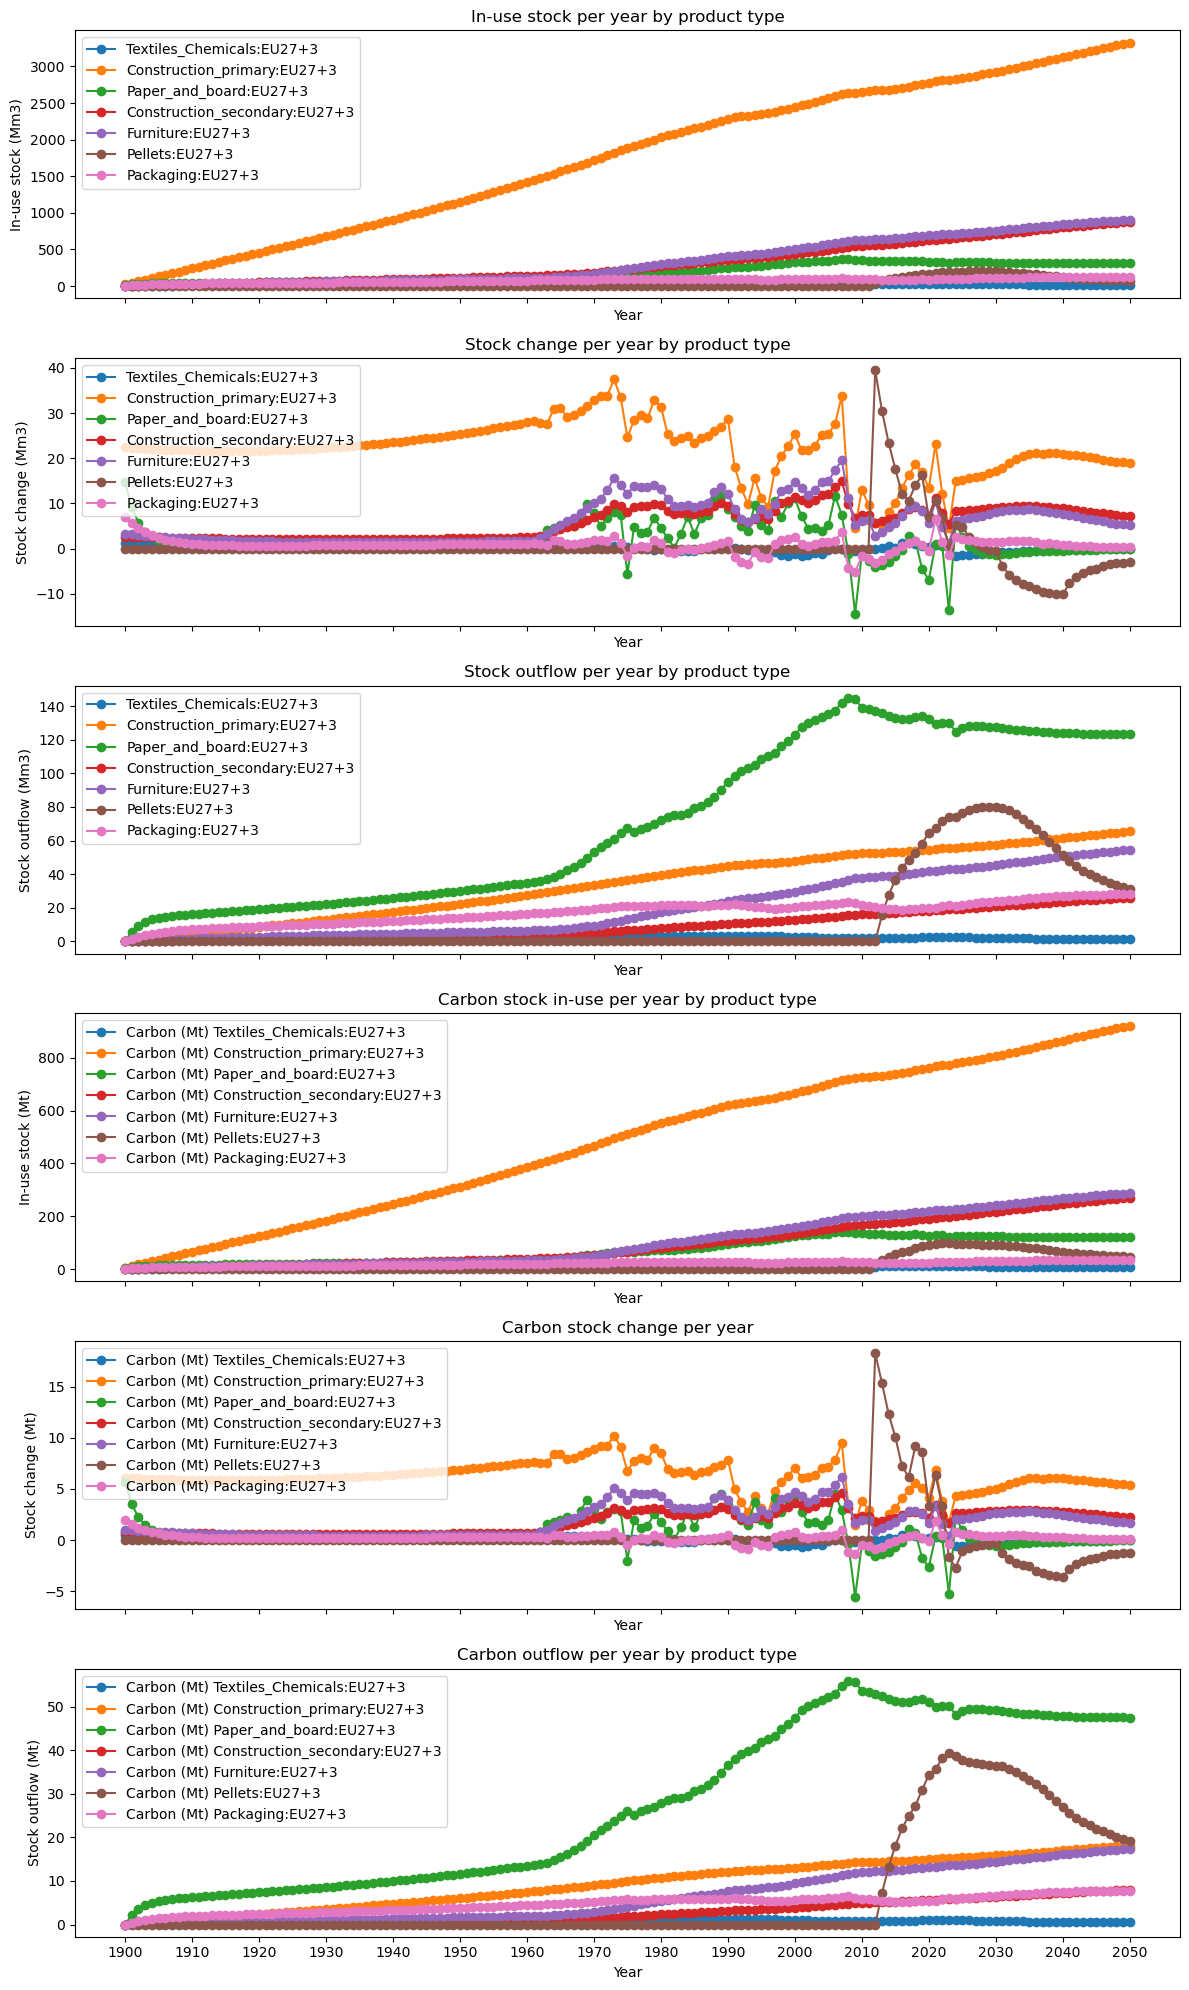

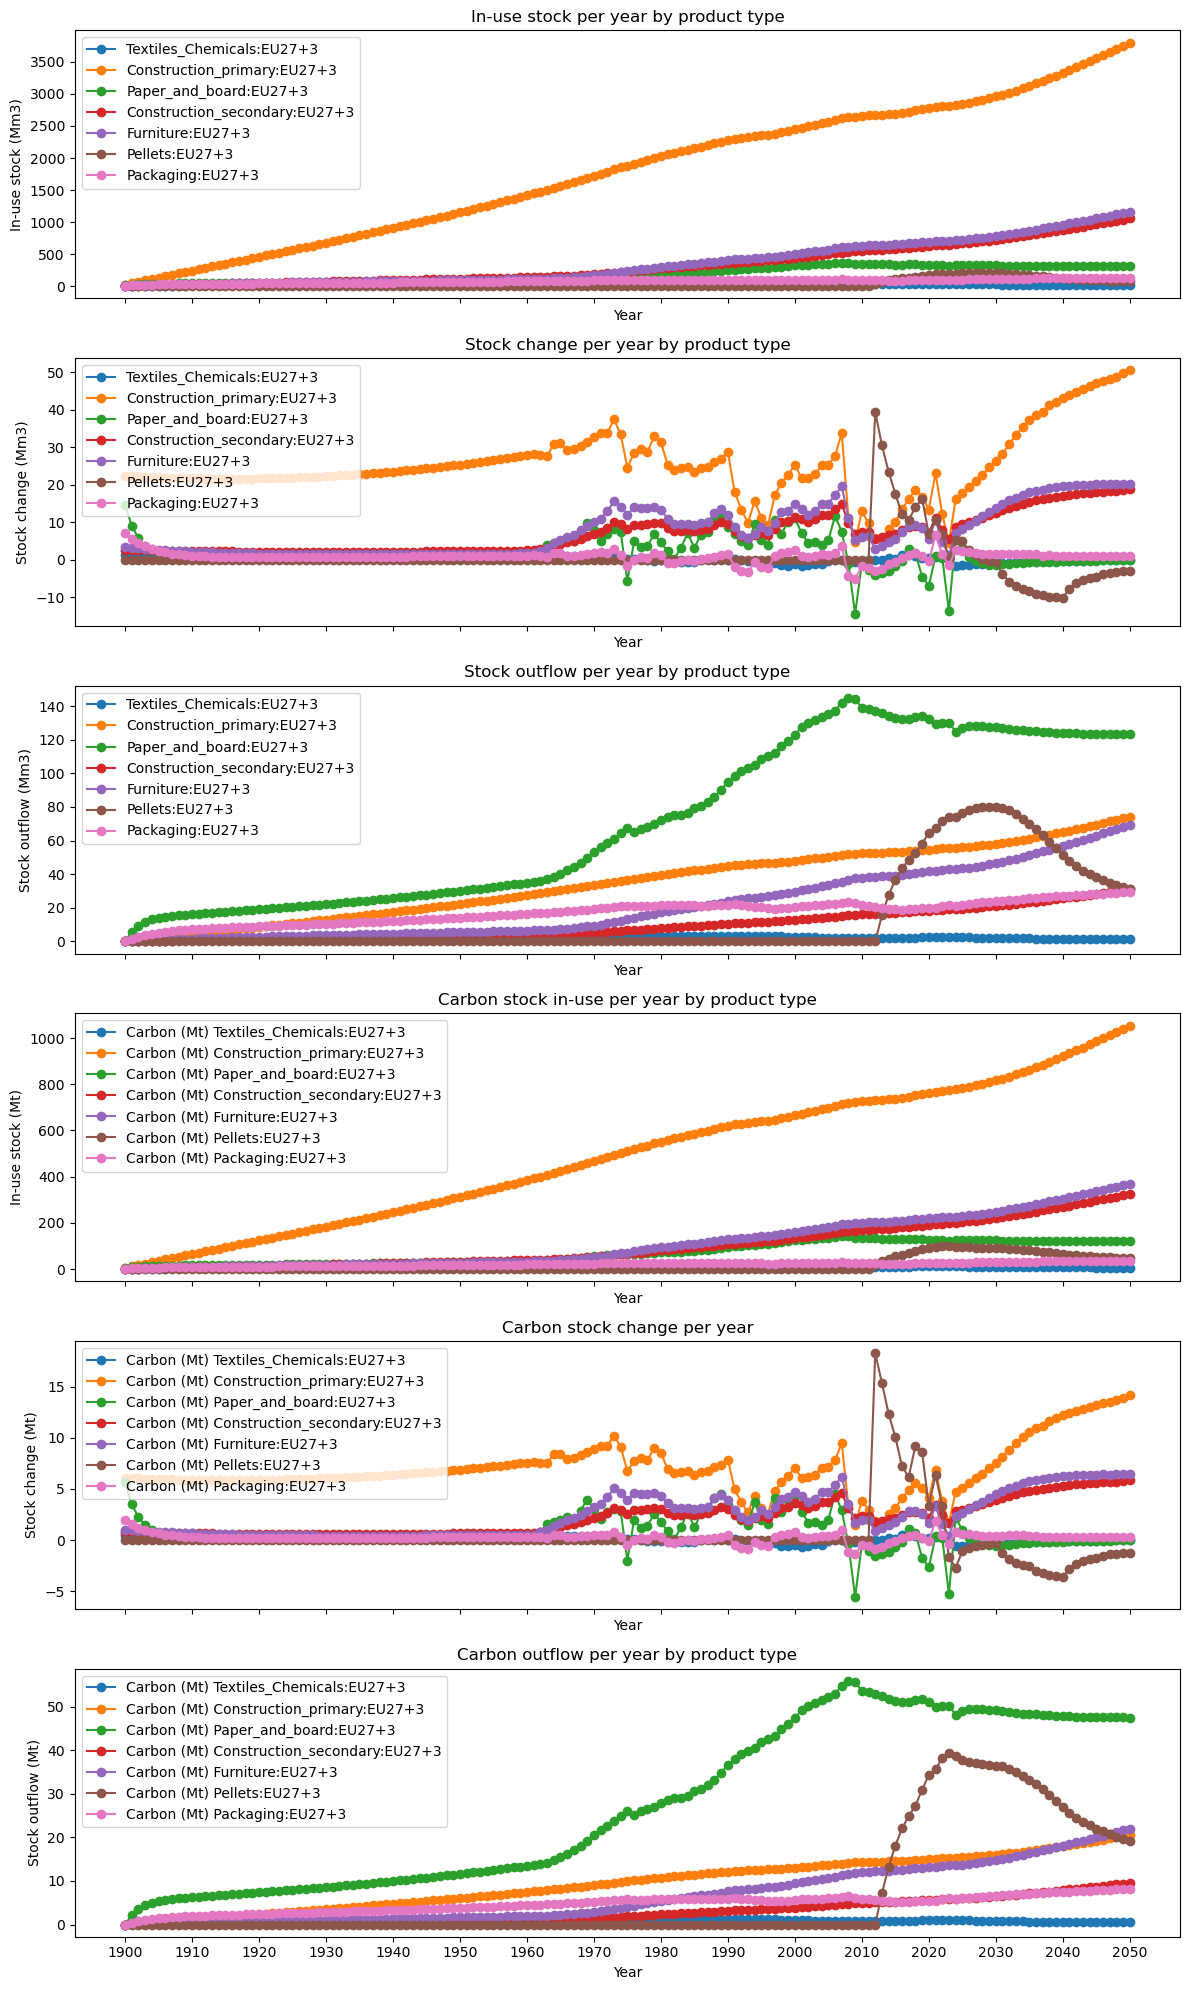

In [267]:
# ****************************************************************************
# * Step 5: Build dynamic stock results for each Scenario and visualize *
# ****************************************************************************

print("Build dynamic stock results...")
for scenario in scenarios:
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years
    scenario_output_path = scenario_name_to_output_path[scenario.name]

    # Full name of the baseline, e.g. "Solid wood equivalent"
    baseline_value_name = scenario.scenario_data.baseline_value_name
    baseline_unit_name = scenario.scenario_data.baseline_unit_name

    # Total number of indicators
    indicators = flow_solver.get_indicator_name_to_indicator()
    num_indicators = len(indicators.keys())

    # Baseline DSM
    stock_id_to_baseline_dsm = flow_solver.get_baseline_dynamic_stocks()
    stock_id_to_indicator_name_to_dsm = flow_solver.get_indicator_dynamic_stocks()

    if not len(stock_id_to_baseline_dsm.keys()):
        print("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    # Each baseline/indicator needs 3 plots
    # so total = baseline (3) + (number of indicators * 3)
    num_subplots = 3 + (num_indicators * 3)
    fig, axes = plt.subplots(num_subplots, 1, sharex='all', sharey='none', figsize=(12, 20))

    # Create an Excel writer for exporting data
    excel_filename = os.path.join(scenario_output_path, f"{scenario.name}_dynamic_stocks.xlsx")
    with pd.ExcelWriter(excel_filename) as writer:

        all_stock_total_dfs = []
        all_stock_change_dfs=[]
        all_stock_outflow_dfs=[]
        for stock_id, baseline_dsm in stock_id_to_baseline_dsm.items():
            plot_index = 0

            # Truncate the stock ID to 20 characters (or any suitable length) to fit within the 31 character limit
            stock_id_for_filename = stock_id[:20]  # Truncate to the first 20 characters
            stock_id_for_filename = stock_id_for_filename.replace(":", "_")  # Replace ":" with "_"

            # ******************
            # * Baseline stock *
            # ******************
            baseline_stock_by_cohort = baseline_dsm.compute_s_c_inflow_driven()
            baseline_outflow_by_cohort = baseline_dsm.compute_o_c_from_s_c()
            baseline_stock_total = baseline_dsm.compute_stock_total()
            baseline_stock_change = baseline_dsm.compute_stock_change()
            baseline_stock_outflow = baseline_dsm.compute_outflow_total()

            # Export stock by cohort
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_s_by_c_{baseline_value_name}')
            df_baseline_stock_by_cohort = pd.DataFrame(baseline_stock_by_cohort, columns=years, index=years)
            df_baseline_stock_by_cohort.to_excel(writer, sheet_name=sheet_name)

            # Export outflow by cohort
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_o_by_c_{baseline_value_name}')
            df_baseline_outflow_by_cohort = pd.DataFrame(baseline_outflow_by_cohort, columns=years, index=years)
            df_baseline_outflow_by_cohort.to_excel(writer, sheet_name=sheet_name)

            # Export stock total
            df_baseline_stock_total = pd.DataFrame(baseline_stock_total, index=years)
            df_baseline_stock_total.reset_index(inplace=True)
            df_baseline_stock_total.columns = ["Year", "Stock total"]
            df_baseline_stock_total["Scenario"] = scenario.name
            df_baseline_stock_total["Stock ID"] = stock_id
            df_baseline_stock_total["Indicator"] =baseline_unit_name
            all_stock_total_dfs.append(df_baseline_stock_total)

            # Export stock change
            df_baseline_stock_change = pd.DataFrame(baseline_stock_change, index=years)
            df_baseline_stock_change.reset_index(inplace=True)
            df_baseline_stock_change.columns = ["Year", "Stock change"]
            df_baseline_stock_change["Scenario"] = scenario.name
            df_baseline_stock_change["Stock ID"] = stock_id
            df_baseline_stock_change["Indicator"] =baseline_unit_name
            all_stock_change_dfs.append(df_baseline_stock_change)

            # Export stock outflow total
            df_baseline_stock_outflow = pd.DataFrame(baseline_stock_outflow, index=years)
            df_baseline_stock_outflow.reset_index(inplace=True)
            df_baseline_stock_outflow.columns = ["Year", "Stock outflow total"]
            df_baseline_stock_outflow["Scenario"] = scenario.name
            df_baseline_stock_outflow["Stock ID"] = stock_id
            df_baseline_stock_outflow["Indicator"] =baseline_unit_name
            all_stock_outflow_dfs.append(df_baseline_stock_outflow)


            # Plot baseline stock total (in-use stocks)
            axes[plot_index + 0].plot(years, baseline_stock_total, marker='o', label="{}".format(stock_id))
            axes[plot_index + 0].set_ylabel("In-use stock ({})".format(baseline_unit_name))
            axes[plot_index + 0].set_title("In-use stock per year by product type")

            # Plot baseline stock change
            axes[plot_index + 1].plot(years, baseline_stock_change, marker='o', label=f'{stock_id}')
            axes[plot_index + 1].set_ylabel("Stock change ({})".format(baseline_unit_name))
            axes[plot_index + 1].set_title("Stock change per year by product type")

            # Plot baseline outflow by cohort
            axes[plot_index + 2].plot(years, baseline_stock_outflow, marker='o', label=f'{stock_id}')
            axes[plot_index + 2].set_ylabel("Stock outflow ({})".format(baseline_unit_name))
            axes[plot_index + 2].set_title("Stock outflow per year by product type")

            plot_index += 3
            for indicator_name, indicator_dsm in stock_id_to_indicator_name_to_dsm[stock_id].items():
                # **************
                # * Indicators *
                # **************
                indicator_unit = indicators[indicator_name].unit

                indicator_stock_by_cohort = indicator_dsm.compute_s_c_inflow_driven()
                indicator_outflow_by_cohort = indicator_dsm.compute_o_c_from_s_c()
                indicator_stock_total = indicator_dsm.compute_stock_total()
                indicator_stock_change = indicator_dsm.compute_stock_change()
                indicator_stock_outflow = indicator_dsm.compute_outflow_total()

                # Export indicator stock by cohort
                sheet_name = shorten_sheet_name(f"{stock_id_for_filename}_s_by_c_{indicator_name}")
                df_indicator_stock_by_cohort = pd.DataFrame(indicator_stock_by_cohort, columns=years, index=years)
                df_indicator_stock_by_cohort.to_excel(writer, sheet_name=sheet_name)

                # Export indicator outflow by cohort
                sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_o_by_c_{indicator_name}')
                df_indicator_oc = pd.DataFrame(indicator_outflow_by_cohort, columns=years, index=years)
                df_indicator_oc.to_excel(writer, sheet_name=sheet_name)

                # Export indicator stock total
                df_indicator_stock_total = pd.DataFrame(indicator_stock_total, index=years)
                df_indicator_stock_total.reset_index(inplace=True)
                df_indicator_stock_total.columns = ["Year", "Stock total"]
                df_indicator_stock_total["Scenario"] = scenario.name
                df_indicator_stock_total["Stock ID"] = stock_id
                df_indicator_stock_total["Indicator"] = indicator_name
                all_stock_total_dfs.append(df_indicator_stock_total)

                #df_indicator_stock_total.to_excel(writer, sheet_name=sheet_name)

                # Export indicator stock change
                df_indicator_stock_change = pd.DataFrame(indicator_stock_change, index=years)
                df_indicator_stock_change.reset_index(inplace=True)
                df_indicator_stock_change.columns = ["Year", "Stock change"]
                df_indicator_stock_change["Scenario"] = scenario.name
                df_indicator_stock_change["Stock ID"] = stock_id
                df_indicator_stock_change["Indicator"] =indicator_name
                all_stock_change_dfs.append(df_indicator_stock_change)

                # Export indicator stock outflow total
                df_indicator_stock_outflow = pd.DataFrame(indicator_stock_outflow, index=years)
                df_indicator_stock_outflow.reset_index(inplace=True)
                df_indicator_stock_outflow.columns = ["Year", "Stock outflow total"]
                df_indicator_stock_outflow["Scenario"] = scenario.name
                df_indicator_stock_outflow["Stock ID"] = stock_id
                df_indicator_stock_outflow["Indicator"] =indicator_name
                all_stock_outflow_dfs.append(df_indicator_stock_outflow)

                # Plot indicator stock total (in-use stocks)
                axes[plot_index + 0].plot(years, indicator_stock_total, marker='o', label='{} ({}) {}'.format(
                    indicator_name, indicator_unit, stock_id))
                axes[plot_index + 0].set_ylabel("In-use stock ({})".format(indicator_unit))
                axes[plot_index + 0].set_title("{} stock in-use per year by product type".format(indicator_name))

                # Plot indicator stock change
                axes[plot_index + 1].plot(years, indicator_stock_change, marker='o', label="{} ({}) {}".format(
                    indicator_name, indicator_unit, stock_id))
                axes[plot_index + 1].set_ylabel("Stock change ({})".format(indicator_unit))
                axes[plot_index + 1].set_title("{} stock change per year".format(indicator_name))

                # Plot indicator outflow by cohort
                axes[plot_index + 2].plot(years, indicator_stock_outflow, marker='o', label="{} ({}) {}".format(
                    indicator_name, indicator_unit, stock_id
                ))
                axes[plot_index + 2].set_ylabel("Stock outflow ({})".format(indicator_unit))
                axes[plot_index + 2].set_title("{} outflow per year by product type".format(indicator_name))

                plot_index += 3

        if all_stock_total_dfs:
            combined_stock_total_df = pd.concat(all_stock_total_dfs, ignore_index=True)
            combined_sheet_name = "Total_stock"
            combined_stock_total_df.to_excel(writer, sheet_name=combined_sheet_name, index=False)

        if all_stock_change_dfs:
            combined_stock_change_df = pd.concat(all_stock_change_dfs, ignore_index=True)
            combined_sheet_name = "Total_stock_change"
            combined_stock_change_df.to_excel(writer, sheet_name=combined_sheet_name, index=False)

        if all_stock_outflow_dfs:
            all_stock_outflow_dfs = pd.concat(all_stock_outflow_dfs, ignore_index=True)
            combined_sheet_name = "Total_stock_outflow"
            all_stock_outflow_dfs.to_excel(writer, sheet_name=combined_sheet_name, index=False)

        # Set common properties to axes
        range_x_ticks = range(min(years), max(years) + 1)
        for axis in axes:
            axis.set_xlabel("Year")
            axis.title.set_size(12)
            axis.legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        filename = os.path.join(scenario_output_path, "{}_stock_plots_by_product.svg".format(scenario.name))
        plt.savefig(filename, format='svg')

        if model_params[ParameterName.ShowPlots]:
            plt.show()

Calculating annual CO2 stock emissions / removals results...
Exporting annual CO2 emissions / removal (Mt) by stock results...
Exporting annual CO2 net emitter years (where removals < 0)...

Steady-state periods for scenario 'Baseline':
  Textiles_Chemicals:EU27+3: 1902 to 2048 (82 years)
  Construction_primary:EU27+3: 1902 to 2048 (106 years)
  Paper_and_board:EU27+3: 1904 to 2048 (85 years)
  Construction_secondary:EU27+3: 1902 to 2048 (114 years)
  Furniture:EU27+3: 1902 to 2048 (95 years)
  Pellets:EU27+3: 1902 to 2048 (132 years)
  Packaging:EU27+3: 1902 to 2048 (96 years)
Exporting annual CO2 emissions / removal (Mt) by stock results...
Exporting annual CO2 net emitter years (where removals < 0)...

Steady-state periods for scenario 'Scenario 16 (flows to long lived 50% increase)':
  Textiles_Chemicals:EU27+3: 1902 to 2048 (82 years)
  Construction_primary:EU27+3: 1902 to 2048 (115 years)
  Paper_and_board:EU27+3: 1904 to 2048 (85 years)
  Construction_secondary:EU27+3: 1902 to 2

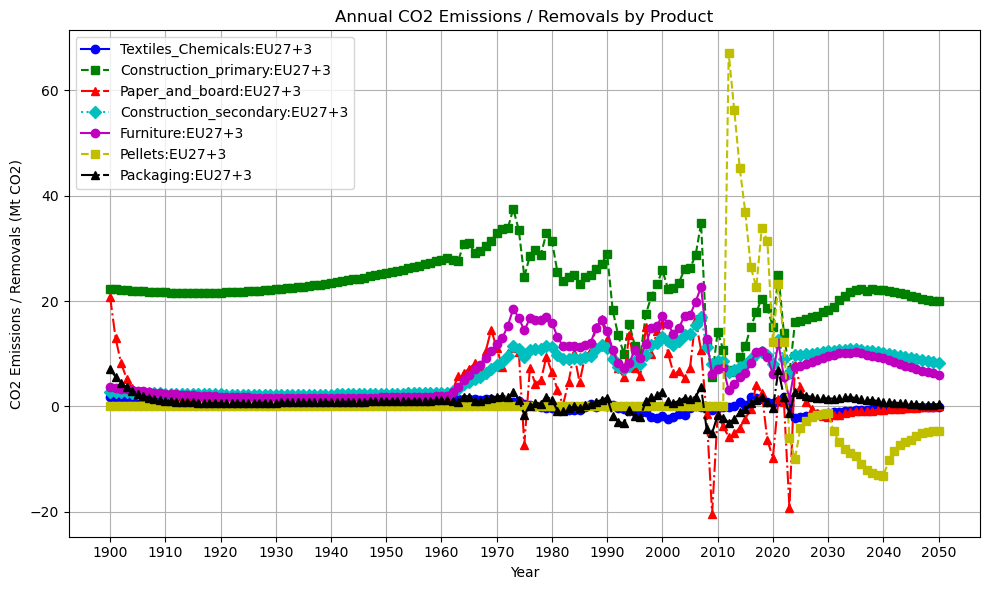

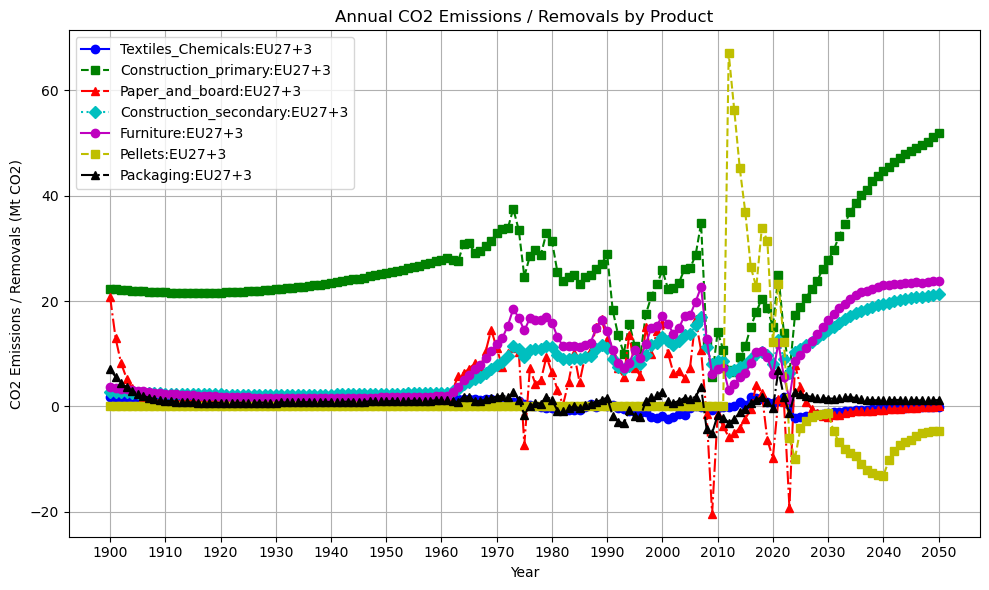

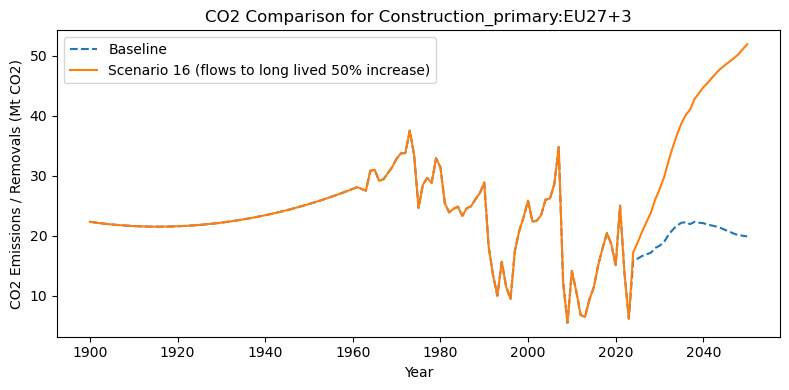

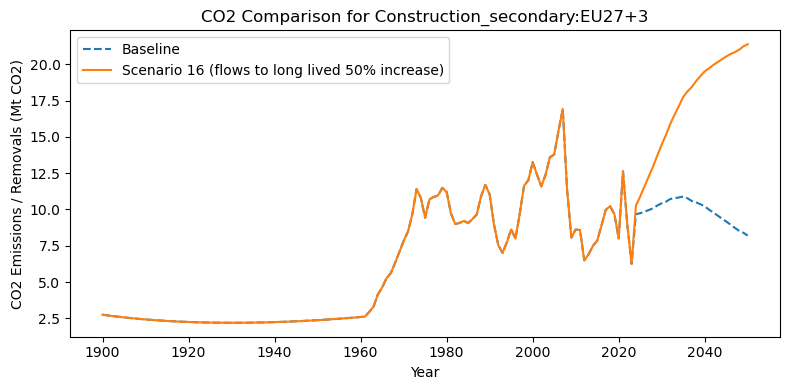

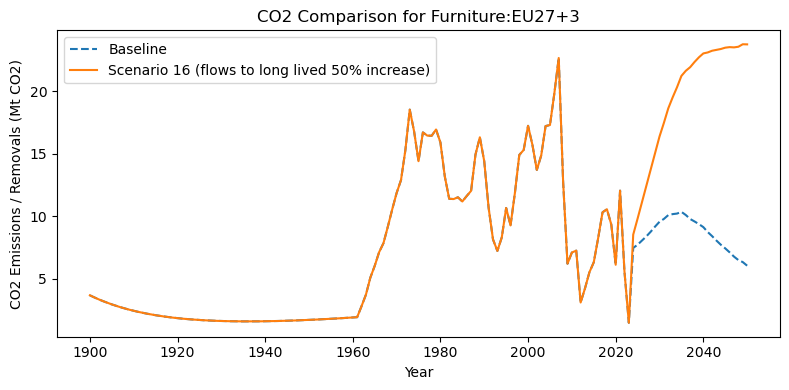

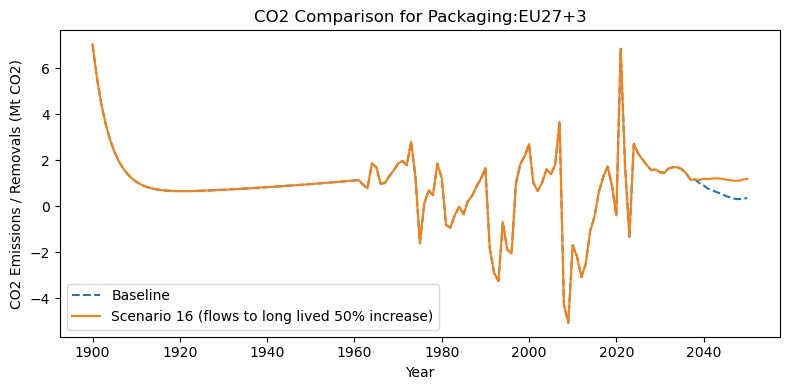

In [276]:
# *****************************************************
# * Step 6: Convert the carbon stocks to CO2 removals *
# *****************************************************
print("Calculating annual CO2 stock emissions / removals results...")

# Storage for comparison
all_scenario_results = {}
all_emitter_years = {}

show_steady_state_overlay = False  # Toggle to enable/disable overlay
steady_state_threshold_ratio = 0.05  # Relative threshold for stability
min_steady_state_years = 5  # Minimum consecutive years for valid steady state

for scenario in scenarios:
    scenario_output_path = scenario_name_to_output_path[scenario.name]
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years
    year_start = scenario.scenario_data.start_year

    stock_id_to_indicator_name_to_dsm = flow_solver.get_indicator_dynamic_stocks()
    if not len(stock_id_to_indicator_name_to_dsm.keys()):
        print("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    results_co2_removals = pd.DataFrame({'Year': years})
    results_net_emitters = pd.DataFrame({'Year': years})
    conversion_factor_c_to_co2 = model_params[ParameterName.ConversionFactorCToCO2]

    # Define line styles, markers, and colors for differentiation
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    target_indicator_name = "Carbon"
    plt.figure(figsize=(10, 6))

    scenario_results = {}
    steady_state_info = {}
    net_emitter_info = {}

    for index, (stock_id, indicator_name_to_dsm) in enumerate(stock_id_to_indicator_name_to_dsm.items()):
        if target_indicator_name not in indicator_name_to_dsm:
            continue

        dsm = indicator_name_to_dsm[target_indicator_name]
        total_inflows_carbon = dsm.i
        total_outflows_carbon = dsm.o
        annual_co2_removal = (total_inflows_carbon - total_outflows_carbon) * conversion_factor_c_to_co2
        results_co2_removals[stock_id] = annual_co2_removal
        scenario_results[stock_id] = annual_co2_removal

# Detect steady-state years with rolling window approach
        threshold = steady_state_threshold_ratio * max(abs(annual_co2_removal))
        rolling_mean = pd.Series(annual_co2_removal).rolling(window=min_steady_state_years, center=True).mean()
        is_steady = abs(pd.Series(annual_co2_removal) - rolling_mean) < threshold

# Extract consecutive steady years
        steady_years = []
        current_run = []
        for year, steady in zip(years, is_steady):
            if steady:
                current_run.append(year)
            else:
                if len(current_run) >= min_steady_state_years:
                    steady_years.extend(current_run)
                current_run = []
        if len(current_run) >= min_steady_state_years:
            steady_years.extend(current_run)

        steady_state_info[stock_id] = sorted(set(steady_years))

        # Detect net emitter years (negative removals)
        emitter_years = [year for year, value in zip(years, annual_co2_removal) if value < 0]
        results_net_emitters[stock_id] = ["Emitter" if value < 0 else "" for value in annual_co2_removal]
        net_emitter_info[stock_id] = emitter_years

        # Plot CO2 removals with steady state overlay
        line_style = line_styles[index % len(line_styles)]
        marker = markers[index % len(markers)]
        color = colors[index % len(colors)]
        plt.plot(years, annual_co2_removal, marker=marker, linestyle=line_style, color=color,
                 label=f'{stock_id}')
        if show_steady_state_overlay and steady_years:
            plt.axvspan(steady_years[0], steady_years[-1], color=color, alpha=0.1)


    all_scenario_results[scenario.name] = scenario_results
    all_emitter_years[scenario.name] = net_emitter_info

    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions / Removals (Mt CO2)')
    plt.title('Annual CO2 Emissions / Removals by Product')
    plt.grid(True)
    tick_gap = 1 if len(years) < 15 else 10
    plt.xticks(years[::tick_gap])
    plt.legend()
    plt.tight_layout()

    # Export CO2 removal data to CSV
    print("Exporting annual CO2 emissions / removal (Mt) by stock results...")
    filename = os.path.join(scenario_output_path, f"{scenario.name}_annual_co2_removal_by_stock.csv")
    results_co2_removals.to_csv(path_or_buf=filename, index=False, mode="w")

    # Export net emitter flag table
    print("Exporting annual CO2 net emitter years (where removals < 0)...")
    filename = os.path.join(scenario_output_path, f"{scenario.name}_annual_net_emitter_flags.csv")
    results_net_emitters.to_csv(path_or_buf=filename, index=False, mode="w")

    # Export CO2 removal plot as SVG
    filename = os.path.join(scenario_output_path, f"{scenario.name}_annual_co2_removal_by_product.svg")
    plt.savefig(filename, format='svg')

    if model_params[ParameterName.ShowPlots]:
        plt.show()

    # Print and export steady-state info
    print(f"\nSteady-state periods for scenario '{scenario.name}':")
    for stock_id, years_list in steady_state_info.items():
        if years_list:
            print(f"  {stock_id}: {years_list[0]} to {years_list[-1]} ({len(years_list)} years)")
        else:
            print(f"  {stock_id}: No steady-state period detected.")

    steady_state_df = pd.DataFrame([
        {'Stock': stock_id, 'StartYear': years_list[0] if years_list else None,
         'EndYear': years_list[-1] if years_list else None, 'DurationYears': len(years_list)}
        for stock_id, years_list in steady_state_info.items()
    ])
    filename = os.path.join(scenario_output_path, f"{scenario.name}_steady_state_periods.csv")
    steady_state_df.to_csv(filename, index=False)

# Statistical comparison against baseline
print("\nPerforming statistical comparison against baseline...")
import scipy.stats as stats

baseline_name = scenarios[0].name
baseline_results = all_scenario_results[baseline_name]

for scenario in scenarios[1:]:
    scenario_name = scenario.name
    scenario_results = all_scenario_results[scenario_name]
    print(f"\nComparison: {scenario_name} vs {baseline_name}")

    for stock_id in baseline_results:
        if stock_id not in scenario_results:
            continue

        baseline_values = baseline_results[stock_id]
        scenario_values = scenario_results[stock_id]

        if not np.allclose(baseline_values, scenario_values, atol=1e-3):
            t_stat, p_value = stats.ttest_rel(baseline_values, scenario_values)
            print(f"  Stock: {stock_id}")
            print(f"    - Mean (baseline): {np.mean(baseline_values):.2f} Mt")
            print(f"    - Mean ({scenario_name}): {np.mean(scenario_values):.2f} Mt")
            print(f"    - Std Dev (baseline): {np.std(baseline_values):.2f} Mt")
            print(f"    - Std Dev ({scenario_name}): {np.std(scenario_values):.2f} Mt")
            print(f"    - Net Balance Change: {sum(scenario_values) - sum(baseline_values):.2f} Mt")
            print(f"    - p-value: {p_value:.4f}")

            # Save plot for changed stocks
            plt.figure(figsize=(8, 4))
            plt.plot(years, baseline_values, label=f"{baseline_name}", linestyle="--")
            plt.plot(years, scenario_values, label=f"{scenario_name}", linestyle="-")
            plt.title(f"CO2 Comparison for {stock_id}")
            plt.xlabel("Year")
            plt.ylabel("CO2 Emissions / Removals (Mt CO2)")
            plt.legend()
            plt.tight_layout()
            comp_filename = os.path.join(scenario_name_to_output_path[scenario_name], f"comparison_{stock_id}.svg")
            plt.savefig(comp_filename, format="svg")

# Export automatic markdown summary report
print("\nGenerating automatic summary report...")
report_lines = []
report_lines.append("# CO₂ Removal Analysis Summary\n")
for scenario_name, scenario_data in all_scenario_results.items():
    report_lines.append(f"## Scenario: {scenario_name}\n")
    for stock_id, removals in scenario_data.items():
        net_balance = np.sum(removals)
        mean_val = np.mean(removals)
        std_val = np.std(removals)
        emit_years = all_emitter_years[scenario_name].get(stock_id, [])
        report_lines.append(f"- **{stock_id}**: Net balance = {net_balance:.2f} Mt, Mean = {mean_val:.2f} Mt, Std = {std_val:.2f} Mt\n")
        if emit_years:
            report_lines.append(f"    - Emits CO₂ in years: {', '.join(map(str, emit_years))}\n")
report_text = "\n".join(report_lines)
summary_filename = os.path.join(scenario_name_to_output_path[baseline_name], "summary_report.md")
with open(summary_filename, "w", encoding="utf-8") as f:
    f.write(report_text)
print(f"Summary report saved to: {summary_filename}")

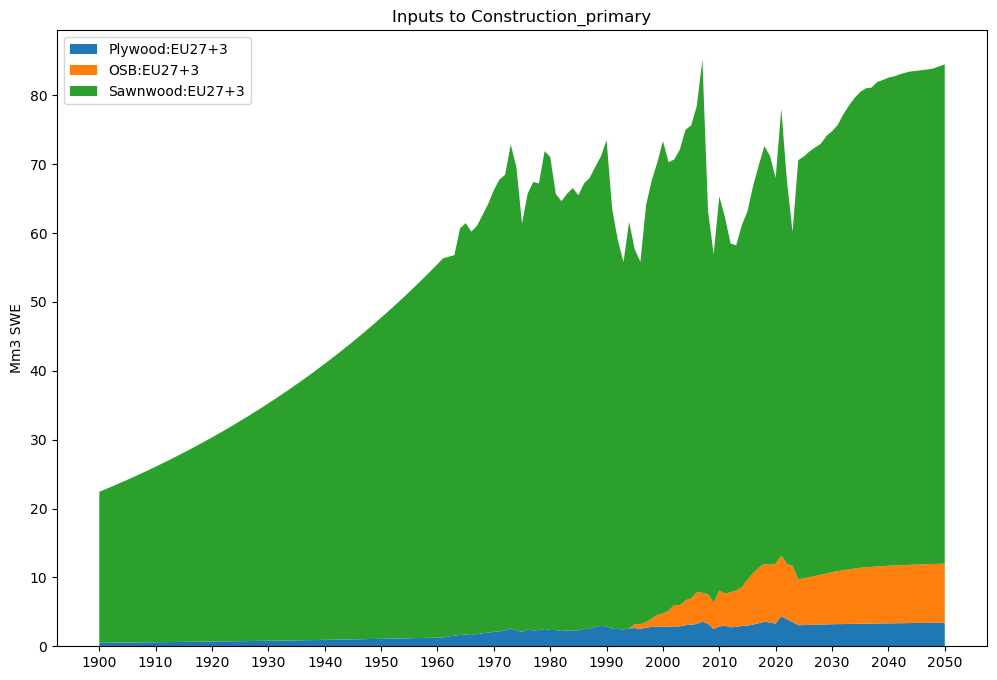

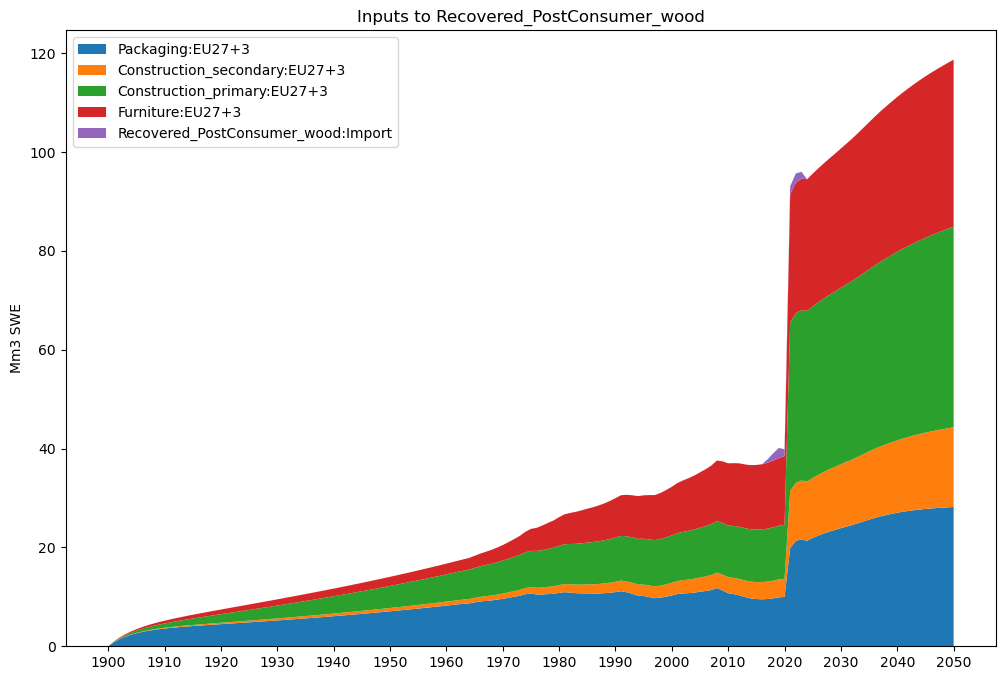

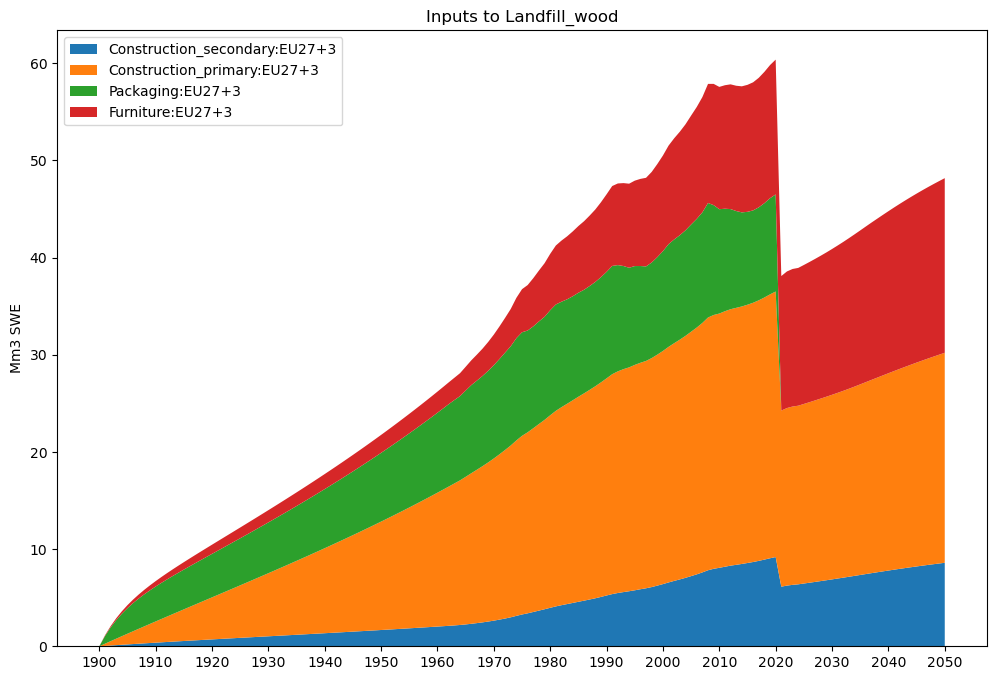

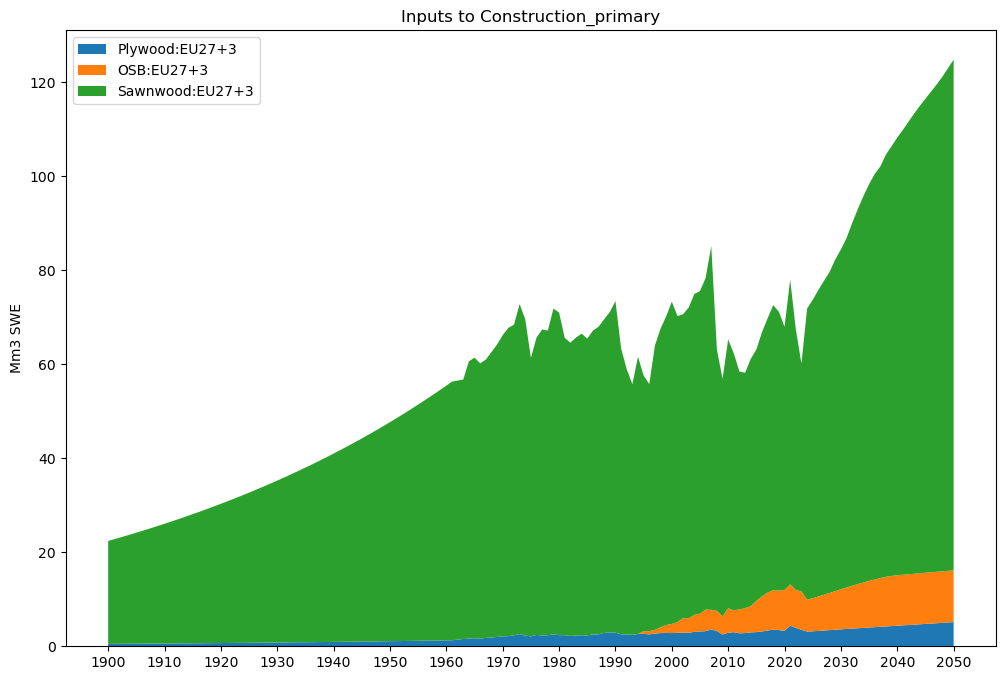

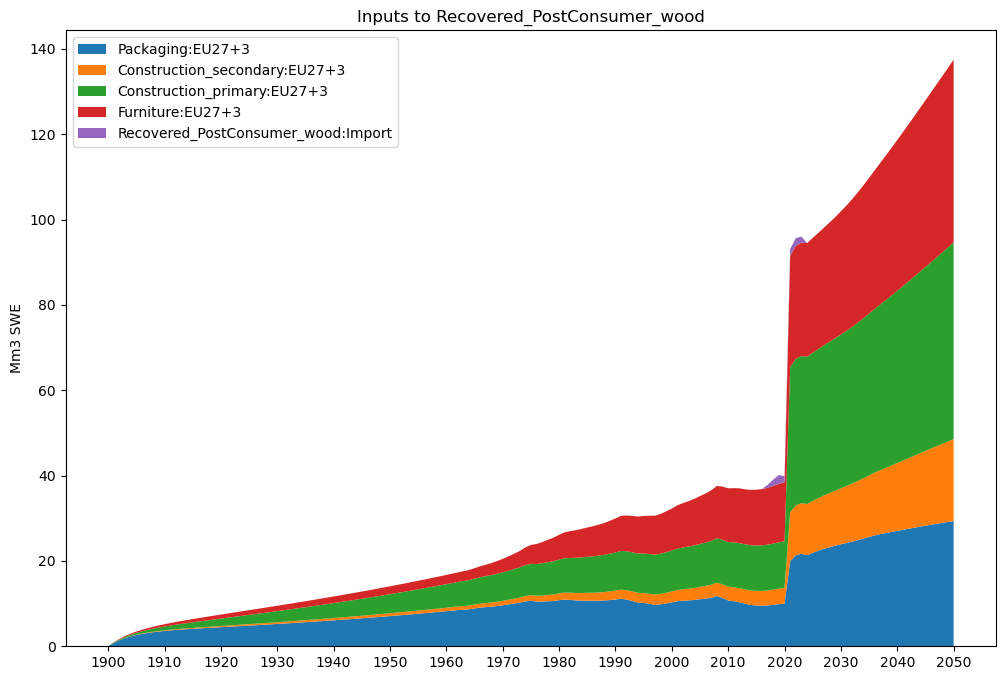

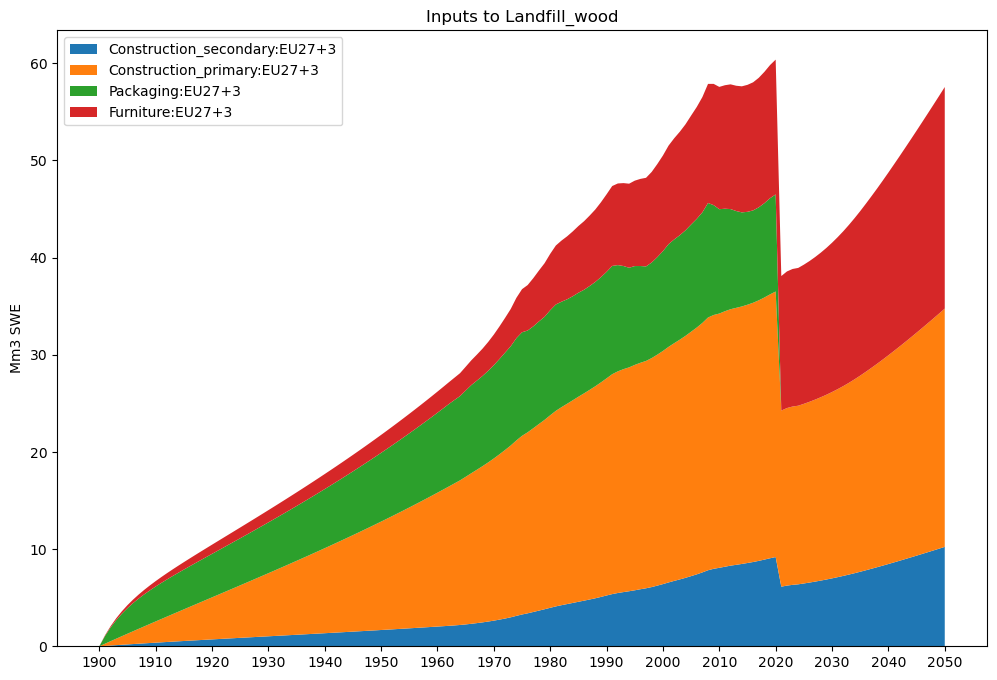

In [269]:
# ************************************************************
# * Step 7: Visualize inflows per year to selected processes *
# ************************************************************

# This is only done only when there is multiple years
# Visualize inflows per year to processes
visualize_inflows_to_process_ids = model_params[ParameterName.VisualizeInflowsToProcesses]
for scenario in scenarios:
    scenario_output_path = scenario_name_to_output_path[scenario.name]
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years

    # Dictionary: Process ID to process
    unique_processes = flow_solver.get_unique_processes()
    for process_id in visualize_inflows_to_process_ids:
        process = flow_solver.get_process(process_id, min(years))
        flow_id_to_source_process_id = {}
        source_process_names = []

        # Find all source processes of all incoming flows to this process in all years
        # This is needed to create stable set of process names so that the relative
        # position of the processes stay the same in stacked chart between the years
        source_process_ids = set()
        for year in years:
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            unique_flow_ids = set()
            for flow in inflows:
                unique_flow_ids.add(flow.id)
                flow_id_to_source_process_id[flow.id] = flow.source_process_id

            # Find source process ID of each incoming flow and add
            # to list of unique source process IDs if not already there
            unique_flow_ids = list(unique_flow_ids)
            for flow_id in unique_flow_ids:
                source_process_ids.add(flow_id_to_source_process_id[flow_id])

        # Now source_process_ids-list contains list of all the possible process IDs
        # that have flows incoming to process_id. This list is needed to keep the
        # incoming process IDs the same every year because aiphoria allows the connections
        # between the flows to change between the years.
        source_process_ids = list(source_process_ids)

        # Create 2D array with shape of (number of source process IDs, number of years)
        # and fill with the value of the inflow from source process for each year
        df_inflows_to_process = pd.DataFrame(columns=['Year', 'Source Process ID', 'Value ({})'.format(
            model_params[ParameterName.BaselineUnitName])])
        source_process_by_flow_values = np.ndarray(shape=(len(source_process_ids), len(years)))
        for year_index, year in enumerate(years):
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            for flow in inflows:
                source_process_id_index = source_process_ids.index(flow.source_process_id)
                source_process_by_flow_values[source_process_id_index, year_index] = flow.evaluated_value
                df_inflows_to_process.loc[len(df_inflows_to_process)] = [year, flow.source_process_id,
                                                                         flow.evaluated_value]
        df_inflows_to_process = df_inflows_to_process.round(5)

        # Export inflows to process to CSV file
        # NOTE: Replace character ':' in Process ID to underscore because Windows system are not able to handle that character in filename
        process_id_for_filename = process_id.replace(":", "_")
        filename = os.path.join(scenario_output_path,
                                "{}_inflows_to_{}.csv".format(scenario.name, process_id_for_filename))
        df_inflows_to_process.to_csv(path_or_buf=filename, index=False, mode="w")

        # Initialize the figure and axes for the stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.stackplot(years, source_process_by_flow_values, labels=list(source_process_ids))
        ax.set_ylabel("Mm3 SWE")
        ax.set_title("Inputs to {}".format(process.name))
        ax.legend(loc='upper left')
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        filename = os.path.join(scenario_output_path,
                                "{}_inflows_to_{}.svg".format(scenario.name, process_id_for_filename))
        plt.savefig(filename, format='svg')

        if model_params[ParameterName.ShowPlots]:
            plt.show()


In [270]:
# *****************************************************
# * Step 8: Visualize the flow graph as Sankey graph *
# *****************************************************

# Create color name to color value mapping
transformation_stage_name_to_color = {color.name: color.value for color in dataprovider.get_color_definitions()}

# Virtual process graph label overrides
# TODO: Move also this to settings file?
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    # TODO: Move this to settings file?
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": transformation_stage_name_to_color,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",
    #"virtual_process_color": "#707070",

    # Color for virtual flows
    "virtual_flow_color": "#808080",
}

# NOTE: Now each scenario is in it's own graph
if model_params[ParameterName.CreateSankeyCharts]:
    visualizer = DataVisualizer()
    visualizer.build_and_show(scenarios, visualizer_params, model_params)
